# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to use machine learning algorithms to precict the personality type of a person given their written text in English. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from userson [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [1]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag


from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score

import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from mbti import run_models, preprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Random Seed for everything
SEED = 53188535

In [2]:
# Loading the Data
cafe_df = pd.read_csv('data/mbti_1.csv')

In [3]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [4]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
cafe_df['type'].value_counts(normalize=True)

INFP    0.211182
INFJ    0.169452
INTP    0.150317
INTJ    0.125764
ENTP    0.078963
ENFP    0.077810
ISTP    0.038847
ISFP    0.031239
ENTJ    0.026628
ISTJ    0.023631
ENFJ    0.021902
ISFJ    0.019135
ESTP    0.010259
ESFP    0.005533
ESFJ    0.004841
ESTJ    0.004496
Name: type, dtype: float64

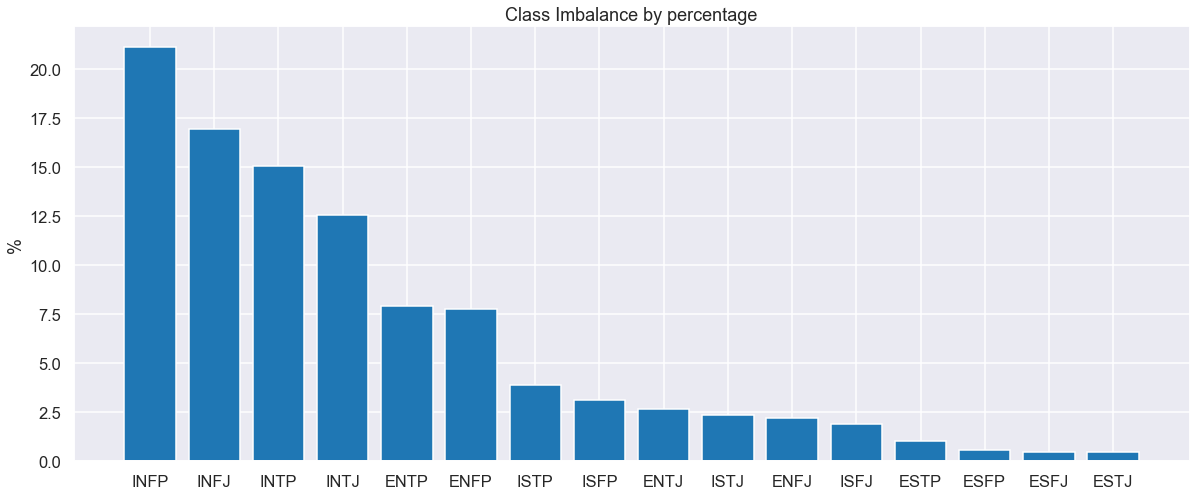

In [6]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [7]:
# looking at a random posts
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can sometimes be quite rude...

>>>>>>>>>>ENFJ<<<<<<<<<<
-------------------------
'oops double post|||Funny how MBTI pigeon holes everyone and turns things into a hate fest. There's no way you can make sense of anything that you analyze at face value, it's errors like this that you have the idea of...|||Am i reading things wrong? or is this like..y'know? *Edit* oh nvm i see D: , i thought it was an error|||Funny i had an english assignment due like last friday and i handed it in this friday. I've never handed anything so late before-good thing there was another ENFJ that procrastinated like me :D. And...|||I don't agree with MBTI type population stats. I think all types are around equal, source: Socionic Type Distribution Statistics  Despite it being socionics, it's still very relevant  Then...|||My grandpa's....or was it my moms. Aside from the jars...sometime my mom would teach me these chinese poem things about flowers falling-and i would recite them whenever i BEAT the flowers >:D|||My ESTP brother and I broke a

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- There are definitely incorrect spellings of words and acroynms like `lol` & `btw`
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [8]:
cafe_clean = cafe_df.copy()

In [9]:
# Lowercase y variables
cafe_clean['type'] = cafe_clean.type.str.lower()

# Creating list of the targets
mbti_lst = list(set(cafe_clean['type'].values))

# Lowercase X varaible onto a new column
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [10]:
# Bringing in the prepreoccess class from mbti.py
# This class provides functions to clean and tokenize our text data
prepro = preprocess()

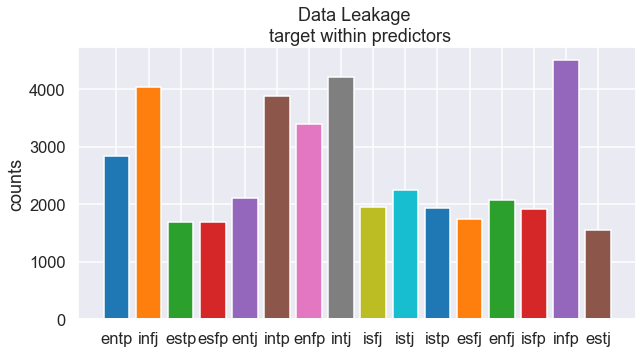

In [11]:
plt.figure(figsize=(10,5))
for mbti in mbti_lst:
    plt.bar(str(mbti), len(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index))
    plt.title('Data Leakage \n target within predictors')
    plt.ylabel('counts')
    # print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [12]:
# Remove the target names in the actual posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.replace_mbti(x))

In [13]:
cafe_clean

,type,posts,clean_posts
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsxhcwe3krw|||...
1,entp,'I'm finding the lack of me in these posts ver...,'i'm finding the lack of me in these posts ver...
2,intp,'Good one _____ https://www.youtube.com/wat...,'good one _____ https://www.youtube.com/wat...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","'dear , i enjoyed our conversation the other..."
4,entj,'You're fired.|||That's another silly misconce...,'you're fired.|||that's another silly misconce...
...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,'https://www.youtube.com/watch?v=t8edhb_h908||...
8671,enfp,'So...if this thread already exists someplace ...,'so...if this thread already exists someplace ...
8672,intp,'So many questions when i do these things. I ...,'so many questions when i do these things. i ...
8673,infp,'I am very conflicted right now when it comes ...,'i am very conflicted right now when it comes ...


In [14]:
for mbti in mbti_lst:
    print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [15]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.pipe_remove(x))

# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.url_remove(x))

# This function will remove punctuation (dependent on what is passed in). This has `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.punc_remove(x))

# Removes all characters that are not American Standard Code for Information Interchange
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.remove_symbols(x))

# Fixes all spelling errors
# cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.spelling(x))

In [16]:
# This will create a column of cleaned words that have been tokenized.
pattern = r"(?u)\b\w\w+\b" # words with more than 2 letters
tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer
cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize) # Tokenize to new column

In [17]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_dig_token(x))

# Removing stopwords
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_stopwords(x))

# Lemmatizing the words with POS tagging
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.lemmend_pos(x, pos=False)) # If true, takes a while (3mins)

In [18]:
# Joining the tokens together into one long string
cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.join_tokens(x)) # Creating new column

In [19]:
# showing what characters are in the cleaned text vs. the pre-cleaned text
clean_corpus = ' '.join(cafe_clean['joined_tokens'])
print(f'CLEANED: {"".join(sorted(set(clean_corpus.lower())))}')
print('-'*25)
print('-'*25)


corpus = ' '.join(cafe_df['posts'])
print(f'PRE-CLEANED: {"".join(sorted(set(corpus.lower())))}')

CLEANED:  abcdefghijklmnopqrstuvwxyz
-------------------------
-------------------------
PRE-CLEANED:  !#$%&'()*+,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~¡¢£¤§¨©«¬®¯°²³´µ¶·¸¹º»¼½¾¿×ßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿāăćčđēĕėęěīĭıłńōŏőœřśšūżưǝɐɔəɛɟɥɪɯɹʇʊʌʍʎʒʖʘ˂˃ˆˈˌː˘˙˚˝˶̴̶̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̯̰̳̹̺̻̼͇͈͉͍͎̀́̂̃̄̆̇̈̉̌̎̐̑̒̓̔̽̾́̓͊̕̚ͅ͏͓͔͕͖͙͚͑͒͛ͣͤͥͦͧͨͩͫͭͮ͘͜͟͢͝͞͡άέήίαβγδεηθικλμνξοπρςστυφψωόύώабвгдежзийклмнопрстуфхцчшщъыьэюяћќ҉אבגדהוזחיךלםמןנסעפץרשת،؟أابةتثجحدرزسشظعغفقكلمنهوي٩کگی۶ःतमरिू्ஐ௰ಠಡಥರೃฅง็๑ຈ༼༽ლღᆺ፦ᴗởἓἔἶὅὐὲ–—―‘’‚“”„†•…′‽‿⁎₪€™↑→↔⇑⇩∀∇∈∑−∙√∞≈≠≡≥≦≧⊃⊙⋆⌒⌣─━┌┐┬┻╥╬╭╮╯■□▬△▽◇◉●◔◕◞◠◡☂★☆☺☼♉♡♢♤♥♧♪♫♬✌✍✓✔✝✧✨✿❤⸮、。》あいうえおかがきぎくこごさざしじすせぜそただちっつづてでとなにねのはへぼまめもゃやょよらりるれろわをん゜アイクサジタッツトニノミメモュラレヮワン・ーヽヾㅿ一上不中之习了事二人仙会但你便像光全兴冬刀利到勇吉同吗吞呢喜四因国地夜夢大天太头好如学安実容小就弁待很我才把抜拿掌文斎斬新方日明易是智暗曉月望本柳欢気汉漫為然爱狼王白的益眼砂祥私笑組美聖花英菀西見語语说迎返違選都野関陰陽雪願馬髒高龍녕디랑뮤보비사석세씨아안오요유재저직하️︵﹏！％＇（）＊，－０１：；？＠｀ａｂｃｄｅｆｇｈｉｋｌｍｎｏｐｒｓｔｕｖｗｘｙ～｡･ｧｩｫｬｼﾉﾞﾟ￣�🌹🍄🏼🐍👈👋👌👍👏💎💓💖💛🔥🕚😀😁😂😃😄😅😆😇😉😊😋😌😍😎😏😐😓😕😘😜😝😞😡😢😣😧😫😬😮😱😳😴😺🙋🤓🤔🤗🦄


In [20]:
cafe_clean.head(5)

,type,posts,clean_posts,post_tokens,joined_tokens
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"[moment, sportscenter, top, ten, play, prank, ...",moment sportscenter top ten play prank life ch...
1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...
2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear , i enjoyed our conversation the other ...","[dear, enjoyed, conversation, day, esoteric, g...",dear enjoyed conversation day esoteric gabbing...
4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...


---

The pre-cleaned tokens tally up to 10637645 total words
The cleaned tokens tally up to 5378285 total words
--------------------
Each feature in pre-cleaned has on average 1226.0 words
Each feature in cleaned has on average 620.0 words
--------------------
Each feature in pre-cleaned  has a median of 1278.0 words
Each feature has a median of 645.0 words
--------------------
The minimum post in pre-cleaned  is 4 words
The minimum post in cleaned is 0 words
--------------------
The minimum post in pre-cleaned  is 1881 words
The minimum post in cleaned is 916 words
--------------------


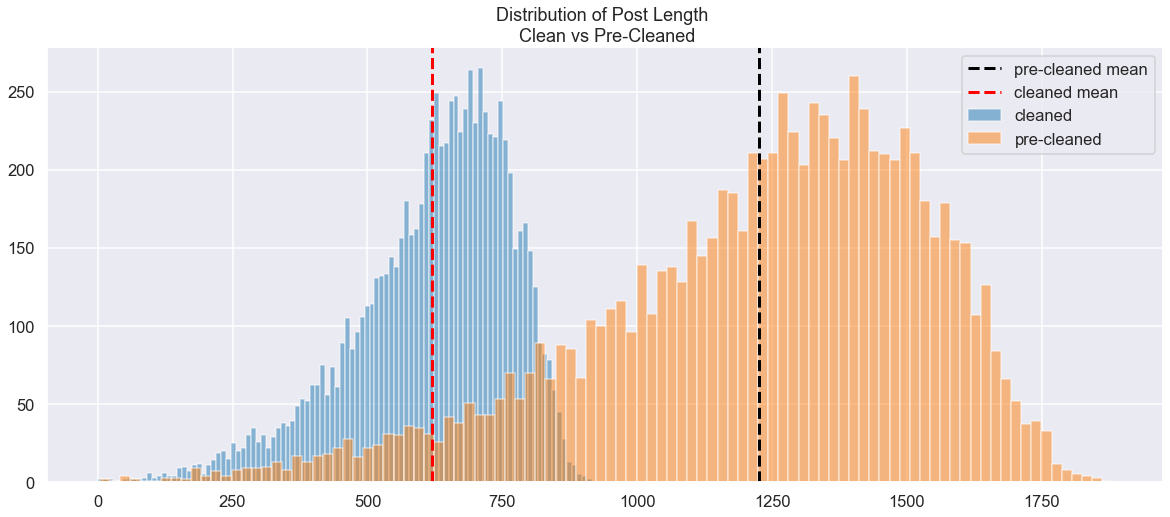

In [21]:
total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean()
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words')

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median()
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min()
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max()
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [22]:
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:1000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:1000])

>>>>>>>>>>INFP<<<<<<<<<<
-------------------------
Sounds like you are in one sided relationships. They should equally be trying to sweep you off your feet. Cheating should never be allowed. It's not so much that it shouldn't be allowed, as it shows...|||I am 30 years old, so I've thought about it, more recently than in my 20's. I do try to have my life open to the possibility of. I recently bought a 3 bedroom house. I am in a pretty solid...|||I definitely get the depressive part. I have learned not drink when I'm pmsing or on my period. I'm already pretty emotional then and it doesn't help. And if I'm feeling down I don't drink. I pretty...|||Haha Probably a bit annoying.|||I think, if the person is a right fit, and the feeling is mutual it should be easy to get together. If it isn't easy, it probably is just not going to work out. You should both be making it easy to...|||Yes, I stress eat! I will eat after a stressful night (at the crisis unit). I'll buy burgers and milkshakes, and

#### Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


In [23]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])

In [24]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


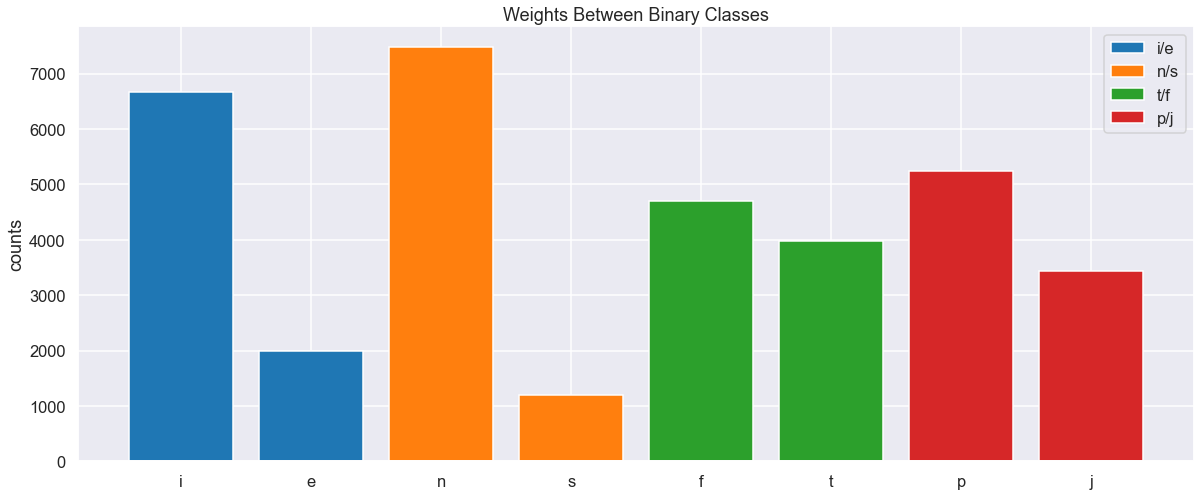

In [25]:
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

### Sentiment Analysis w/ VADER

In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [27]:
sid.polarity_scores(cafe_clean.loc[2,'joined_tokens'])

{'neg': 0.116, 'neu': 0.59, 'pos': 0.294, 'compound': 0.9985}

In [28]:
cafe_clean['sentiment'] = cafe_clean['joined_tokens'].apply(lambda x: sid.polarity_scores(x))

In [29]:
cafe_clean['sentiment_total'] = cafe_clean['sentiment'].apply(lambda x: x['compound'])

In [30]:
cafe_clean['sentiment_score'] = cafe_clean['sentiment_total'].apply(lambda x: '+' if x >= 0 else '-')

Average Sentiemnt Score for entp: 0.9050423357664232
Average Sentiemnt Score for infj: 0.9528048979591837
Average Sentiemnt Score for estp: 0.9536662921348315
Average Sentiemnt Score for esfp: 0.894975
Average Sentiemnt Score for entj: 0.9390021645021644
Average Sentiemnt Score for intp: 0.8614109662576687
Average Sentiemnt Score for enfp: 0.9803294814814817
Average Sentiemnt Score for intj: 0.8973036663611366
Average Sentiemnt Score for isfj: 0.948713855421687
Average Sentiemnt Score for istj: 0.9184565853658537
Average Sentiemnt Score for istp: 0.8667602373887241
Average Sentiemnt Score for esfj: 0.995704761904762
Average Sentiemnt Score for enfj: 0.9782905263157895
Average Sentiemnt Score for isfp: 0.9674929889298893
Average Sentiemnt Score for infp: 0.9306973799126637
Average Sentiemnt Score for estj: 0.8621179487179487


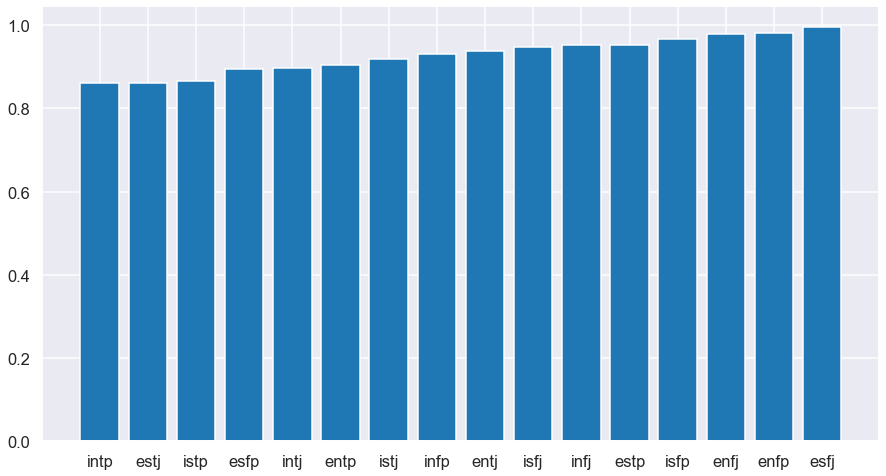

In [31]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);


Average Sentiemnt Score for t: 0.8887170057774428
Average Sentiemnt Score for f: 0.9496621005538988


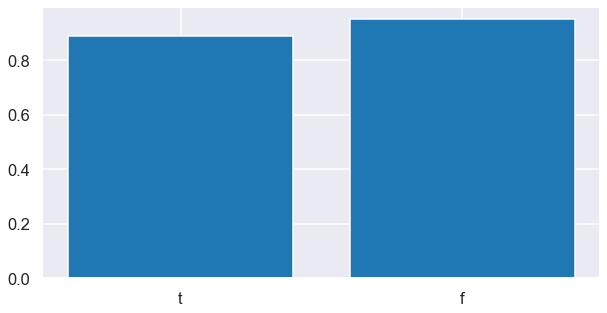

In [32]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

In [33]:
cafe_clean['polarity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [34]:
cafe_clean['subjectivity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

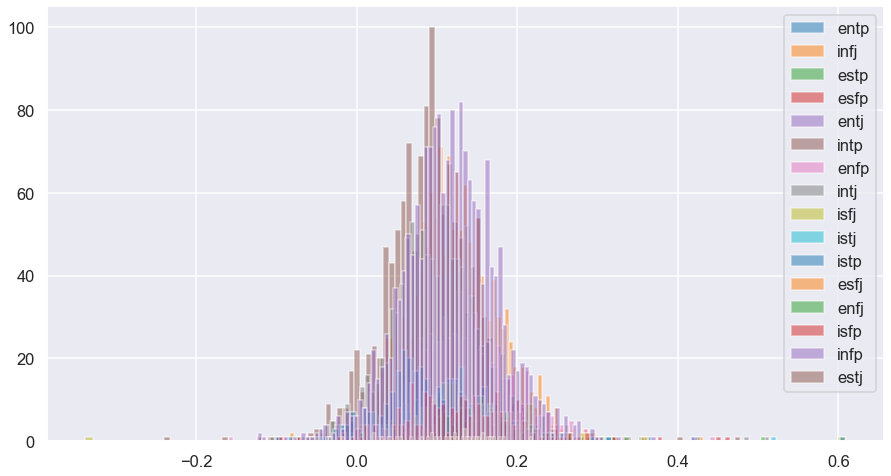

In [35]:
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['polarity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

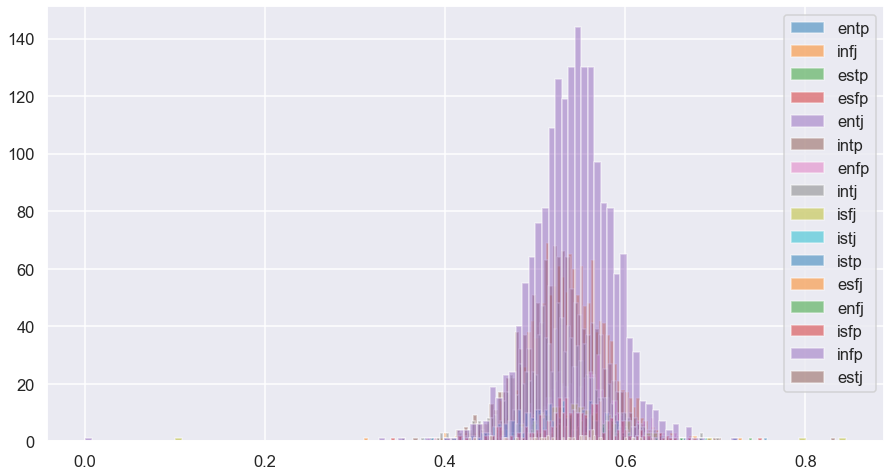

In [36]:
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['subjectivity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

Average Sentiemnt Score for entp: 0.10590090335179567
Average Sentiemnt Score for infj: 0.1214895481202205
Average Sentiemnt Score for estp: 0.11441655908285725
Average Sentiemnt Score for esfp: 0.11010892306760049
Average Sentiemnt Score for entj: 0.11055357819182873
Average Sentiemnt Score for intp: 0.09291757754098166
Average Sentiemnt Score for enfp: 0.1329899337810195
Average Sentiemnt Score for intj: 0.10003048338908699
Average Sentiemnt Score for isfj: 0.1263913355024996
Average Sentiemnt Score for istj: 0.10823278200444438
Average Sentiemnt Score for istp: 0.09588938000598825
Average Sentiemnt Score for esfj: 0.14258469639216373
Average Sentiemnt Score for enfj: 0.14812948692547181
Average Sentiemnt Score for isfp: 0.13004786057170323
Average Sentiemnt Score for infp: 0.11645378762957145
Average Sentiemnt Score for estj: 0.1110576144843595


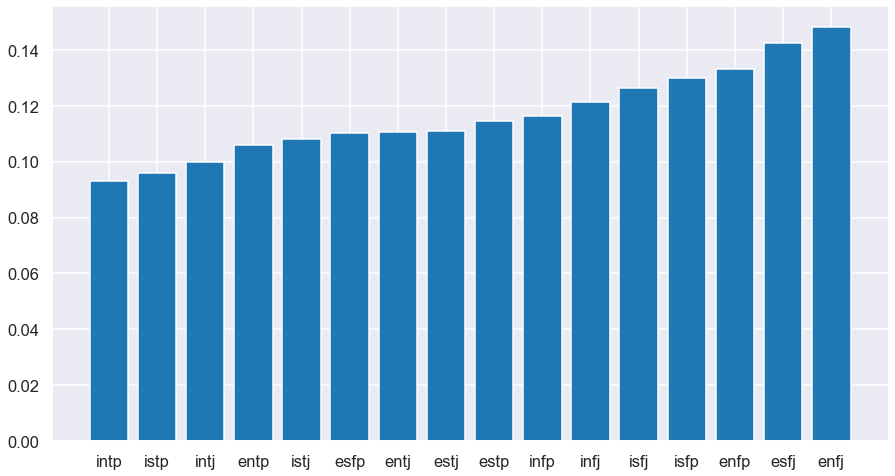

In [37]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);

Average Sentiemnt Score for entp: 0.5380495185560457
Average Sentiemnt Score for infj: 0.5381978583634299
Average Sentiemnt Score for estp: 0.5396800449366442
Average Sentiemnt Score for esfp: 0.5465271837769525
Average Sentiemnt Score for entj: 0.5344430594971704
Average Sentiemnt Score for intp: 0.5275168492543789
Average Sentiemnt Score for enfp: 0.5496365795526645
Average Sentiemnt Score for intj: 0.5267408591515655
Average Sentiemnt Score for isfj: 0.5454440463697302
Average Sentiemnt Score for istj: 0.523997553233744
Average Sentiemnt Score for istp: 0.5285889125896784
Average Sentiemnt Score for esfj: 0.5431285962773988
Average Sentiemnt Score for enfj: 0.5514479594749813
Average Sentiemnt Score for isfp: 0.5441099160846544
Average Sentiemnt Score for infp: 0.5424336702162073
Average Sentiemnt Score for estj: 0.5318460082730709


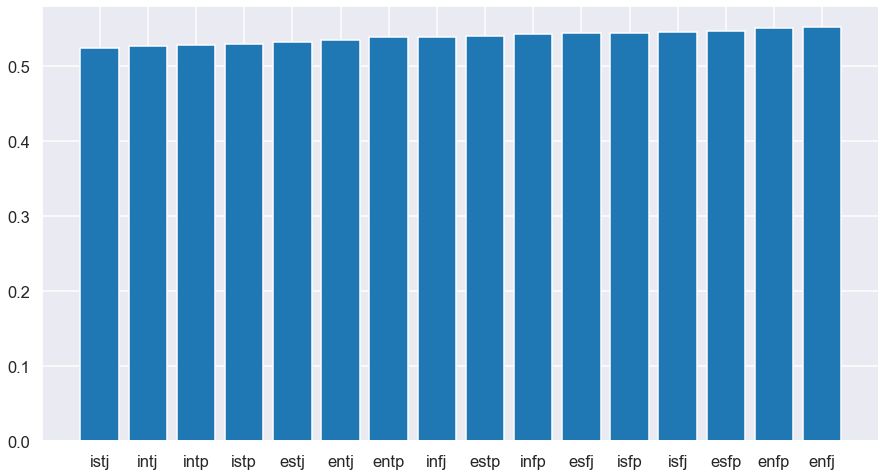

In [38]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);

Average Sentiemnt Score for t: 0.09982279224954028
Average Sentiemnt Score for f: 0.12299605878913275


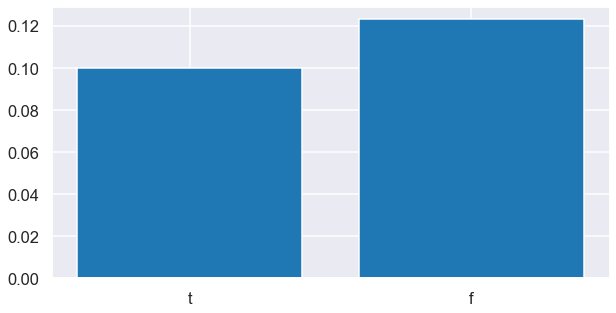

In [39]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

Average Sentiemnt Score for t: 0.5297422748039327
Average Sentiemnt Score for f: 0.5427591273860013


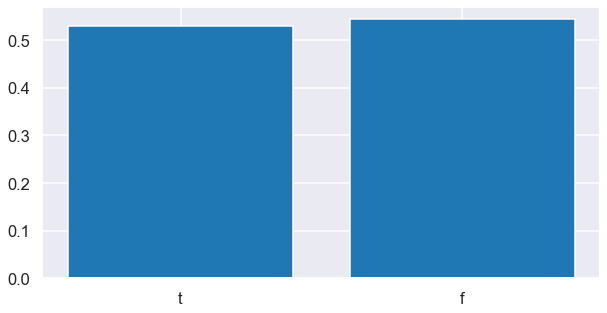

In [40]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

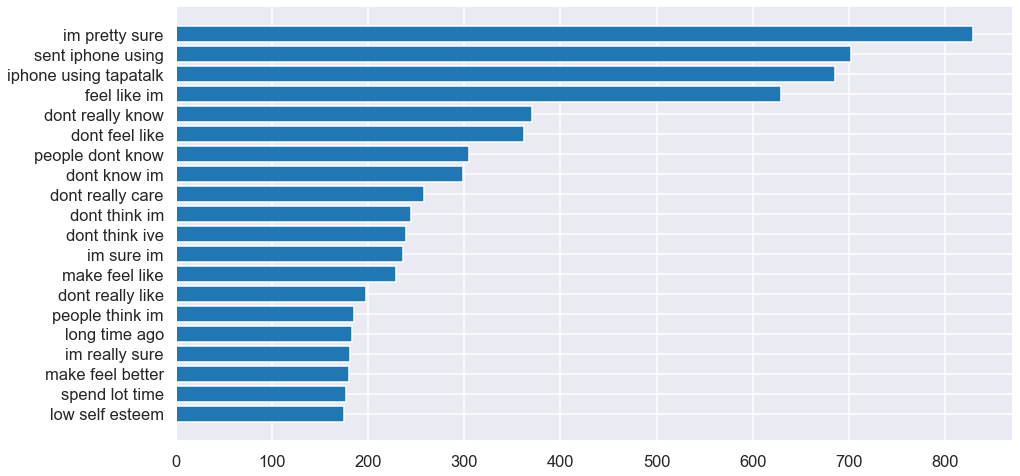

In [41]:
# Susan Li
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
# for word, freq in common_words:
#     print(word, freq)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values);


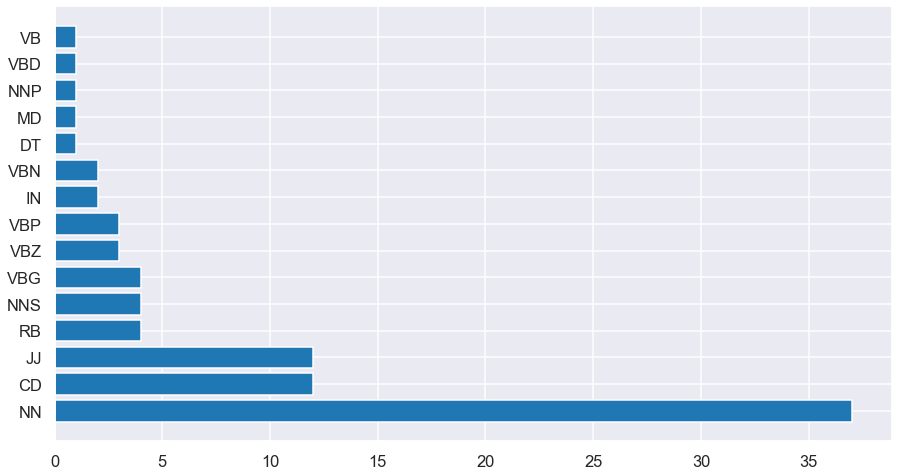

In [42]:
blob = TextBlob(str(cafe_clean['joined_tokens']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(15,8))
plt.barh(pos_df.index, pos_df.values);

In [43]:
cafe_clean.columns

Index(['type', 'posts', 'clean_posts', 'post_tokens', 'joined_tokens', 'i/e',
       'n/s', 't/f', 'p/j', 'sentiment', 'sentiment_total', 'sentiment_score',
       'polarity', 'subjectivity'],
      dtype='object')

In [44]:
print(f"Amount of chars in cropus: {cafe_clean['posts'].apply(lambda x: len(x)).sum()}")

Amount of chars in cropus: 62763535


In [45]:
print(f"Amount of words in corpus: {cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()}")
print(f"Amount of chars in cropus: {cafe_clean['joined_tokens'].apply(lambda x: len(x)).sum()}")
print(f"Average word length:\
 {cafe_clean['joined_tokens'].apply(lambda x: len(x)).sum() / cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()} ")

Amount of words in corpus: 5378285
Amount of chars in cropus: 35472596
Average word length: 6.595521806672573 


In [ ]:
# cafe_clean.to_csv('./data/cafe_clean_pos.csv')

## Baseline Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [ ]:
cafe_clean = pd.read_csv('./data/cafe_clean_pos.csv')

In [ ]:
# Baseline
baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"),

                  'LogisticRegression': LogisticRegression(n_jobs=1, C=.001),

                  'NaiveBayes': MultinomialNB(),
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                  'RandomForest': RandomForestClassifier(max_depth=8, random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

In [ ]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [ ]:
rm = run_models()

In [ ]:
multiclass_cv = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)
multiclass_cv

In [ ]:
multiclass_tfidf = rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)
multiclass_tfidf

In [ ]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .4108)
plt.barh(cafe_clean['type'].value_counts(normalize=True).index, cafe_clean['type'].value_counts(normalize=True).values)
plt.xlim(0, 1)

#### Multiclass Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
multiclass_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)
multiclass_rus_cv

In [ ]:
multiclass_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)
multiclass_rus_tfidf

In [ ]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .1143)
plt.barh('class balance', 1/16)
plt.xlim(0, 1)

In [ ]:
multiclass_cv['other'] = 'countvec'
multiclass_tfidf['other'] = 'tfidf'
multiclass_rus_cv['other'] = 'rus_countvec'
multiclass_rus_tfidf['other'] = 'rus_tfidf'


base_mc = pd.concat([multiclass_cv, multiclass_tfidf, multiclass_rus_cv, multiclass_rus_tfidf])
base_mc

### Multiclass Undersampled Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [ ]:
bin_targets = ['i/e', 'n/s', 't/f', 'p/j']
bin_targets

In [ ]:
bin_cv = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)
bin_cv

In [ ]:
bin_tfidf = rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)
bin_tfidf

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .78)
axs[0, 0].barh(cafe_clean['i/e'].value_counts(normalize=True).index, cafe_clean['i/e'].value_counts(normalize=True).values)

axs[0,1].barh('accuracy', .85)
axs[0,1].barh(cafe_clean['n/s'].value_counts(normalize=True).index, cafe_clean['n/s'].value_counts(normalize=True).values)

axs[1,0].barh('accuracy', .79)
axs[1,0].barh(cafe_clean['t/f'].value_counts(normalize=True).index, cafe_clean['t/f'].value_counts(normalize=True).values)

axs[1,1].barh('accuracy', .68)
axs[1,1].barh(cafe_clean['p/j'].value_counts(normalize=True).index, cafe_clean['p/j'].value_counts(normalize=True).values)

acc = [.78, .85, .79, .68]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    increase = round(acc[i] - cafe_clean[target].value_counts(normalize=True)[0], 2)
    print(f'Accuracy increase from class balance in {target} is: {increase}')
    plt.bar(target, increase)
plt.show();


In [ ]:
bin_rus_cv = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)
bin_rus_cv

In [ ]:
bin_rus_tfidf = rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)
bin_rus_tfidf

In [ ]:
from scipy.stats import binom

In [ ]:
# Probability we are seeing these results given a 50/50 class balance

print(f"Pobability of i/e model: {1 - binom.cdf(k=(1499*2)*.68, n=1499*2, p=0.5)}")
print(f"Pobability of n/s model: {1 - binom.cdf(k=(898*2)*.67, n=(898*2), p=0.5)}")
print(f"Pobability of t/f model: {1 - binom.cdf(k=(1499*2)*.80, n=1499*2, p=0.5)}")
print(f"Pobability of p/j model: {1 - binom.cdf(k=(2575*2)*.67, n=2575*2, p=0.5)}")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .68)
axs[0, 0].barh(['i', 'e'], [.5, .5])

axs[0,1].barh('accuracy', .73)
axs[0,1].barh(['n', 's'], [.5, .5])

axs[1,0].barh('accuracy', .8)
axs[1, 0].barh(['t', 'f'], [.5, .5])

axs[1,1].barh('accuracy', .66)
axs[1,1].barh(['p', 'j'], [.5, .5])

acc = [.68, .73, .8, .66]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    print(f'Accuracy increase from class balance in {target} is: {round(acc[i] - .5, 2)}')
    plt.bar(target, round(acc[i] - .5, 2))


---

## Sequential Neural Network

In [ ]:
# cafe_clean['t/f'] = cafe_clean['t/f'].replace({'t': 0, 'f': 1})

In [ ]:
# cafe_clean.dropna(inplace=True)

In [ ]:
# # Splitting to test and train sets
# X = cafe_clean['joined_tokens']
# y = cafe_clean['t/f']

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y, 
#                                                     test_size= 0.25,
#                                                     stratify=y,
#                                                     random_state=SEED)

In [ ]:
# # Vectorizing and transforming with TfidfVectorizer
# tfidf = TfidfVectorizer(ngram_range=(1,2))

# X_train_vec = tfidf.fit_transform(X_train)
# X_test_vec = tfidf.transform(X_test)

# # View the shapes of X variables
# print('Shape of train features tensor:', X_train_vec.shape)
# print('Shape of test features tensor:', X_test_vec.shape)

# # View the shapes of y variables
# print('Shape of train label tensor:', y_train.shape)
# print('Shape of test label tensor:', y_test.shape)

In [ ]:
# from tensorflow.keras.layers import Dropout, Embedding, SpatialDropout1D, LSTM, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# # Creating Neural Network Model
# model = Sequential()
# model.add(layers.Dense(50, input_dim=(1771357), activation='relu'))
# model.add(Dropout(.5))
# model.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
# # Compiling and running Neural Network
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# history = model.fit(X_train_vec.toarray(), np.array(y_train), epochs=5, batch_size=32, validation_split=.20, verbose=1)

In [ ]:
# # Printing test score accuracy
# results = model.evaluate(X_test_vec.toarray(), np.array(y_test), batch_size=10)
# print("test loss, test acc:", results)

In [ ]:
# # Plotting loss of train and validation sets by epochs
# plt.figure(figsize=(8,5))
# plt.title('Loss')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show();

In [ ]:
# # Plotting accuracy of train and validatio sets by epochs
# plt.figure(figsize=(8,5))
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'], label='train')
# plt.plot(history.history['val_accuracy'], label='validation')
# plt.legend()
# plt.show();

In [ ]:
# # Appending results to metric table
# NN_dict = {'Model': 'NeuralNetwork', 
#             'CV Score': max(history.history['val_accuracy']),
#             'Test Accuracy': results[1],
#             'Type': 'multiclass_NN'}
# NN_row = pd.DataFrame(NN_dict, index=[0])

# metric_table_multi = pd.concat([metric_table_multi, NN_row], ignore_index=True)

---

## Doc2Vec

In [ ]:
cafe_clean = cafe_clean.dropna()

In [ ]:
train_df, test_df = train_test_split(cafe_clean, random_state=SEED)

In [ ]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [ ]:
def tokenize_gens(dataframe):
    for i, post in enumerate(dataframe['joined_tokens']):
        tokens = gensim.utils.simple_preprocess(post)
        yield gensim.models.doc2vec.TaggedDocument(tokens, dataframe.loc[i, 't/f'])

train_corpus = list(tokenize_gens(train_df))
test_corpus = list(tokenize_gens(test_df))

In [ ]:
print(train_corpus[0])

In [ ]:
print(test_corpus[0])

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(dm=1, 
                                    vector_size=50, 
                                    min_count=2, 
                                    epochs=40)

In [ ]:
model.build_vocab(train_corpus)

In [ ]:
# print(f"Word 'feel' appeared {model.wv.get_vecattr('feel', 'count')} times in the training corpus.")
# print(f"Word 'think' appeared {model.wv.get_vecattr('think', 'count')} times in the training corpus.")

In [ ]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
vector = model.infer_vector(['unaware', 'people', 'dont', 'confidence', 'often', 'picture'])
print(vector)

In [ ]:
def vector_for_learning(model, posts):
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in posts])
    return targets, feature_vectors

In [ ]:
y_train, X_train = vector_for_learning(model, train_corpus)
y_test, X_test = vector_for_learning(model, test_corpus)

clf = SGDClassifier(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=.0001, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=25)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'Testing accuracy: {accuracy_score(y_test, y_pred)}')

---

## Model Tuning

In [ ]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')

In [ ]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED, loss="modified_huber"))
])

In [ ]:
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

---

### i/e

In [ ]:
cafe_clean['i/e'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .77, 'n': .23}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['i/e'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### n/s

In [ ]:
cafe_clean['n/s'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .90, 'n': .10}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['n/s']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['n/s'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### t/f

In [ ]:
cafe_clean['t/f'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### p/j

In [ ]:
cafe_clean['p/j'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=50)),
                ('clf', SGDClassifier(class_weight={'p': .40, 'j': .60}, random_state=SEED,  loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['p/j']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['p/j'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

## Final Model

In [2]:
# cafe_clean = pd.read_csv('./data/cafe_clean.csv')
# cafe_clean.dropna(inplace=True)

              precision    recall  f1-score   support

           f       0.80      0.80      0.80      1150
           t       0.77      0.77      0.77      1019

    accuracy                           0.79      2169
   macro avg       0.78      0.78      0.78      2169
weighted avg       0.79      0.79      0.79      2169



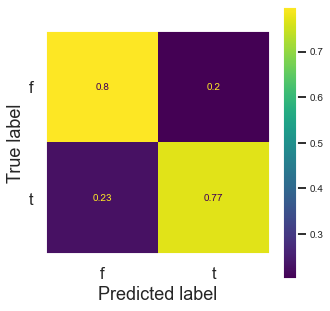

In [47]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2), min_df=50)),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED, loss="modified_huber"))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

In [46]:
import joblib

In [48]:
filename = 'finalized_model.sav'
joblib.dump(final_model, filename)

['finalized_model.sav']

In [ ]:
reddit_sample = pd.read_csv('./data/reddit_sample_clean500.csv')

In [ ]:
reddit_sample[reddit_sample['joined_tokens'].isna() == True]

In [ ]:
reddit_X = reddit_sample['joined_tokens']
reddit_y = reddit_sample['t/f']

y_pred = final_model.predict(reddit_X)
acc_score = accuracy_score(reddit_y, y_pred)

print(classification_report(y_pred=y_pred, y_true=reddit_y, target_names=reddit_sample['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, reddit_X, reddit_y, ax=ax, normalize='true')
plt.grid(False);

In [ ]:
# pickle.dump(final_model, open('./models/final_model.pkl', 'wb'))


In [ ]:
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

print(final_model.predict([f_test_sample])[0], '--', f"{round(max(final_model.predict_proba([f_test_sample])[0])*100, 2)}%")


In [ ]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

print(final_model.predict([t_test_sample])[0], '--', f"{round(max(final_model.predict_proba([t_test_sample])[0])*100, 2)}%")


### Highest TFIDF

In [6]:
train_set, test_set = train_test_split(cafe_clean, random_state=SEED)

In [7]:
X_train_t = train_set[train_set['t/f'] == 't']['joined_tokens']
X_train_f = train_set[train_set['t/f'] == 'f']['joined_tokens']

In [8]:
tfidf_t = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_t = tfidf_t.fit_transform(X_train_t)
feature_array_t = np.array(tfidf_t.get_feature_names())

In [9]:
tfidf_f = TfidfVectorizer(ngram_range=(1,2), min_df=50)

train_tfidf_f = tfidf_f.fit_transform(X_train_f)
feature_array_f = np.array(tfidf_f.get_feature_names())

In [10]:
tfidf_df_t = pd.DataFrame(train_tfidf_t.toarray(), columns=tfidf_t.get_feature_names())
tfidf_df_f = pd.DataFrame(train_tfidf_f.toarray(), columns=tfidf_f.get_feature_names())

In [11]:
highest_tfidf_t = []
for column in tfidf_df_t.columns:
    highest_tfidf_t.append((column, tfidf_df_t[column].max()))

In [12]:
highest_tfidf_f = []
for column in tfidf_df_f.columns:
    highest_tfidf_f.append((column, tfidf_df_f[column].max()))

In [13]:
def getKey(item):
    return item[1]

high_tfidf_t = sorted(highest_tfidf_t, key=getKey, reverse=True)
high_tfidf_f = sorted(highest_tfidf_f, key=getKey, reverse=True)

In [14]:
high_tfidf_f[:5]

[('type likely', 0.8296687237727707),
 ('congrats', 0.8185622995048053),
 ('da', 0.7918117921110335),
 ('sir', 0.7700726251450812),
 ('grateful', 0.7564942644168047)]

In [15]:
high_tfidf_t[:5]

[('youtube', 0.8391669744279399),
 ('type likely', 0.7989372362119583),
 ('ha', 0.7974630459780876),
 ('blushed', 0.7874873975450024),
 ('metal', 0.7769961861565363)]

---

In [4]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [18]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=50)

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

tfidf.fit_transform(X_train, y_train)



<6505x10715 sparse matrix of type '<class 'numpy.float64'>'
	with 2908737 stored elements in Compressed Sparse Row format>

In [22]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [23]:
rint = np.random.randint(0, len(X_test))
feature_array = np.array(tfidf.get_feature_names())
response = tfidf.transform([X_test[rint]])
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
print(y_test[rint])
print(top_n)
print('-'*25)
print(X_test[rint])

f
['im' 'great' 'would great' 'oh im' 'year']
-------------------------
living interesting time le boring stability part world last decade hope im wrong soon lot action im traveling instead buying thing moment im rising budget im going hit road girlfriend longer period take time year save pile love thievery corporation annoying extrovert childhood im completely opposite people life get along trust like recent version much hehehe maybe try online dating case worked perfect okcupid com wrote honestly description found another well found another side glad know im one kind world hehehe thanks usually im hearing something like mean sad weird im reading im telling mind clear tooth stick long distance girlfriend philippine killed oh cute lollipop hehehe lol demisexual couldnt said better cat fantastic creature decided reduce consumption sold car replaced bike got rid lot stuff always prepare meal etc lifestyle probably lead loneliness kind great movie jagten imdb another make plan good mood d

In [24]:
pickle.dump(tfidf, open('./models/final_tfidf.pkl', 'wb'))


## Further Inspect Thinking vs Feeling

In [ ]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

In [ ]:
top_ten = list(zip(*t_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 THINKING Class Word Occurences');

In [ ]:
top_ten = list(zip(*f_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 FEELING Class Word Occurences');

In [ ]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

In [ ]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

---
## Random Sample Reddit

In [ ]:
types = list(cafe_clean['type'].values)
regxx='(intp)|(intj)|(entp)|(entj)|(infj)|(infp)|(enfj)|(enfp)|(istj)|(isfj)|(estj)|(esfj)|(istp)|(isfp)|(estp)|(esfp)|(intp)'

In [ ]:
reddit_df = pd.read_csv("./data/mbti_full_pull.csv")

In [ ]:
reddit_df['author_flair_text'] = reddit_df['author_flair_text'].str.lower()

In [ ]:
reddit_df['t/f'] = reddit_df['author_flair_text'].map(lambda x: x[2])

In [ ]:
reddit_df['t/f'].value_counts()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# instantiating the random undersampler
rus = RandomUnderSampler({'t':1000, 'f':1000}) 

# resampling training set X & y
X_res, y_res = rus.fit_resample(X, y)

y_pred = final_model.predict(X_res)
acc_score = accuracy_score(y_res, y_pred)

print(classification_report(y_pred=y_pred, y_true=y_res, target_names=reddit_df['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

## Thinking vs. Feeling

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


### Word Embeddings

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
from gensim.models import Word2Vec

---

## 500 Set

In [ ]:
df_500 = pd.read_csv('./data/MBTI 500.csv')

In [ ]:
df_500

In [ ]:
df_500['clean_posts'] = df_500['posts'].apply(replace_mbti)

In [ ]:
df_500['type'] = df_500['type'].str.lower()

In [ ]:
len(df_500)

In [ ]:
df_500 = df_500[df_500['clean_posts'].apply(lambda x: len(x.split())) > 450]

In [ ]:
total_words = df_500['clean_posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

print('-'*20)

ave_post = df_500['clean_posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

print('-'*20)

med_post = df_500['clean_posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

print('-'*20)

min_post = df_500['clean_posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

print('-'*20)

max_post = df_500['clean_posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')


print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(df_500['clean_posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [ ]:
# Adding Binary Targets
df_500['i/e'] = df_500['type'].map(lambda x: x[0])
df_500['n/s'] = df_500['type'].map(lambda x: x[1])
df_500['t/f'] = df_500['type'].map(lambda x: x[2])
df_500['p/j'] = df_500['type'].map(lambda x: x[3])

In [ ]:
print(df_500['i/e'].value_counts(normalize=True))
print(df_500['n/s'].value_counts(normalize=True))
print(df_500['t/f'].value_counts(normalize=True))
print(df_500['p/j'].value_counts(normalize=True))

In [ ]:
# Baseline

baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

In [ ]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [ ]:
rm = run_models()

In [ ]:
bin_targets = cafe_clean.columns[-4:]
bin_targets

In [ ]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
df_500

In [ ]:
print(df_500['i/e'].value_counts(normalize=False))
print(df_500['n/s'].value_counts(normalize=False))
print(df_500['t/f'].value_counts(normalize=False))
print(df_500['p/j'].value_counts(normalize=False))

In [ ]:
rm.run_usampled(df_500, 'clean_posts', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
df_500[df_500.clean_posts.str.match(regxx) == True]

In [ ]:
# final_df = pd.read_pickle('./pickle/finalmodeling_df.pkl')

In [ ]:
# final_df.token_joined.str.match(regxx).sum()

In [ ]:
# final_df['token_joined'] = final_df['token_joined'].apply(replace_mbti)

In [ ]:
# final_df = final_df[final_df.token_joined.str.match(regxx) == False]

In [ ]:
# final_df = final_df.reset_index()

In [ ]:
# final_df

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
# print(final_df['i/e'].value_counts(normalize=True))
# print(final_df['n/s'].value_counts(normalize=True))
# print(final_df['t/f'].value_counts(normalize=True))
# print(final_df['p/j'].value_counts(normalize=True))

In [ ]:
# rint = np.random.randint(0, len(final_df))

# print(rint)
# print(final_df['type'].iloc[rint])
# final_df['token_joined'].iloc[rint]

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps